In [2]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report


DATA

In [5]:
root_path = "../input/rice-image-dataset/Rice_Image_Dataset/"
class_names = sorted(os.listdir(root_path))[:-1]
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [6]:
file_path = "../input/rice-image-dataset/Rice_Image_Dataset/"

In [7]:
filepaths = list(glob.glob(file_path + "/**/*.*"))

In [8]:
print(filepaths[0:2])

['../input/rice-image-dataset/Rice_Image_Dataset\\Arborio\\Arborio (1).jpg', '../input/rice-image-dataset/Rice_Image_Dataset\\Arborio\\Arborio (10).jpg']


In [10]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels

['Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Arborio',
 'Ar

In [11]:
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,../input/rice-image-dataset/Rice_Image_Dataset...,Basmati
1,../input/rice-image-dataset/Rice_Image_Dataset...,Basmati
2,../input/rice-image-dataset/Rice_Image_Dataset...,Jasmine
3,../input/rice-image-dataset/Rice_Image_Dataset...,Ipsala
4,../input/rice-image-dataset/Rice_Image_Dataset...,Arborio


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Basmati'),
  Text(1, 0, 'Jasmine'),
  Text(2, 0, 'Ipsala'),
  Text(3, 0, 'Arborio'),
  Text(4, 0, 'Karacadag')])

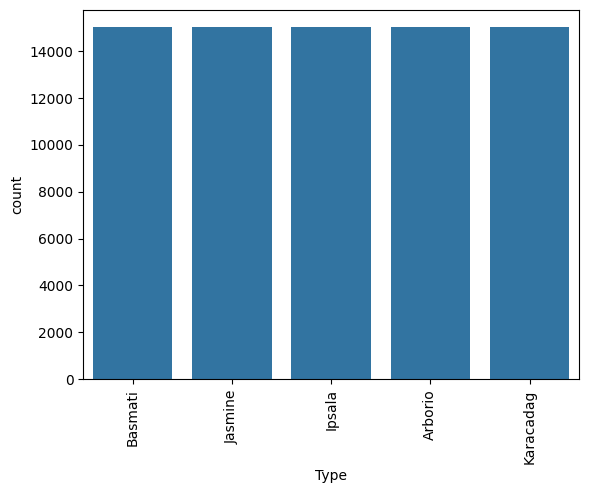

In [12]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)

In [13]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

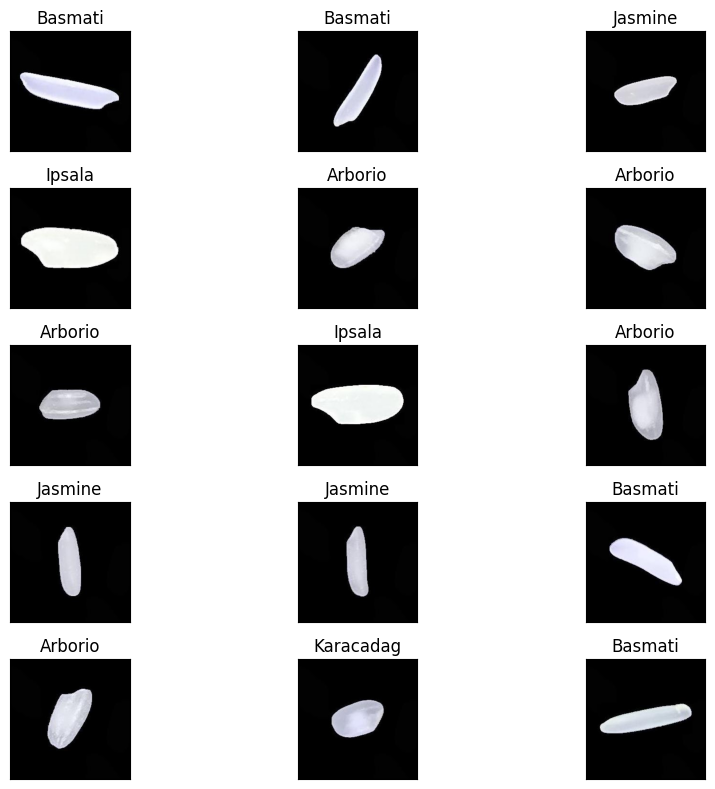

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 8), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat) :
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
    
plt.tight_layout()
plt.show()

In [15]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [16]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False,
    seed = 42
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 56250 validated image filenames belonging to 5 classes.
Found 18750 validated image filenames belonging to 5 classes.
Found 18750 validated image filenames belonging to 5 classes.


In [17]:
pretrained_model = ResNet50(
    input_shape=(100, 100, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

pretrained_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 57s 1us/step


In [19]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(5, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)


In [21]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [22]:
my_callbacks = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [23]:
history = model.fit(
    train_gen, 
    validation_data=valid_gen,
    epochs=10
)

Epoch 1/10


d:\Lainnya\Rice Classification\Env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1066s 602ms/step - accuracy: 0.9520 - loss: 0.1402 - val_accuracy: 0.9810 - val_loss: 0.0546
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 987s 561ms/step - accuracy: 0.9832 - loss: 0.0486 - val_accuracy: 0.9888 - val_loss: 0.0337
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 691s 393ms/step - accuracy: 0.9875 - loss: 0.0363 - val_accuracy: 0.9805 - val_loss: 0.0590
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 657s 374ms/step - accuracy: 0.9897 - loss: 0.0314 - val_accuracy: 0.9819 - val_loss: 0.0559
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 2134s 1s/step - accuracy: 0.9894 - loss: 0.0290 - val_accuracy: 0.9875 - val_loss: 0.0398
Epoch 6/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 913s 519ms/step - accuracy: 0.9918 - loss: 0.0237 - val_accuracy: 0.9921 - val_loss: 0.0250
Epoch 7/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 822s 467ms/step - accuracy: 0.9929 - loss: 0.0211 - val_accuracy: 0.9906 - val_loss: 0.0291
Epoch 8/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 923s 525ms/step - accuracy: 0.99

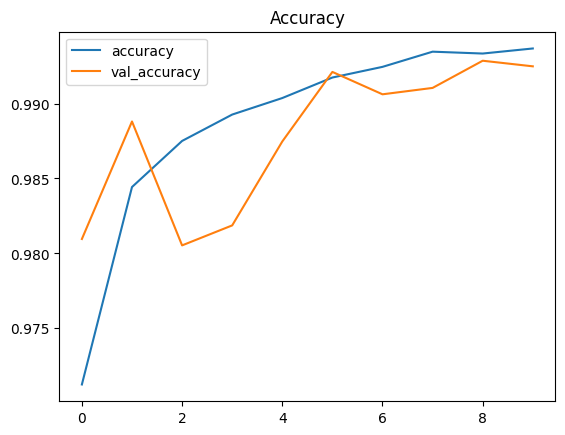

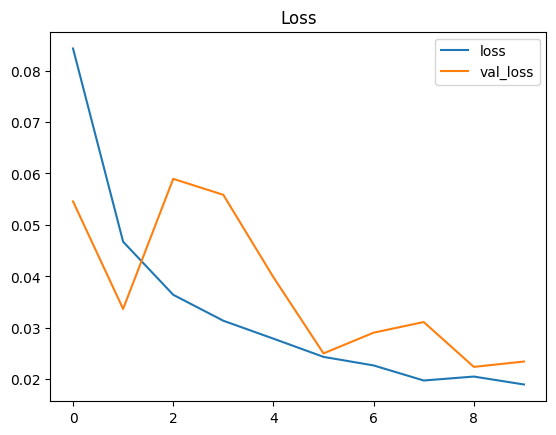

In [27]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()


In [28]:
result = model.evaluate(test_gen, verbose=0)
print(" Test Loss: {:.5f}".format(result[0]))
print("Test Accuracy: {:.2f}".format(result[1]*100))

d:\Lainnya\Rice Classification\Env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Test Loss: 0.02345
Test Accuracy: 99.25


In [29]:
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)


labels= (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


586/586 ━━━━━━━━━━━━━━━━━━━━ 185s 313ms/step


In [30]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      3707
     Basmati       0.99      0.99      0.99      3820
      Ipsala       1.00      1.00      1.00      3821
     Jasmine       0.99      0.99      0.99      3693
   Karacadag       0.99      0.99      0.99      3709

    accuracy                           0.99     18750
   macro avg       0.99      0.99      0.99     18750
weighted avg       0.99      0.99      0.99     18750



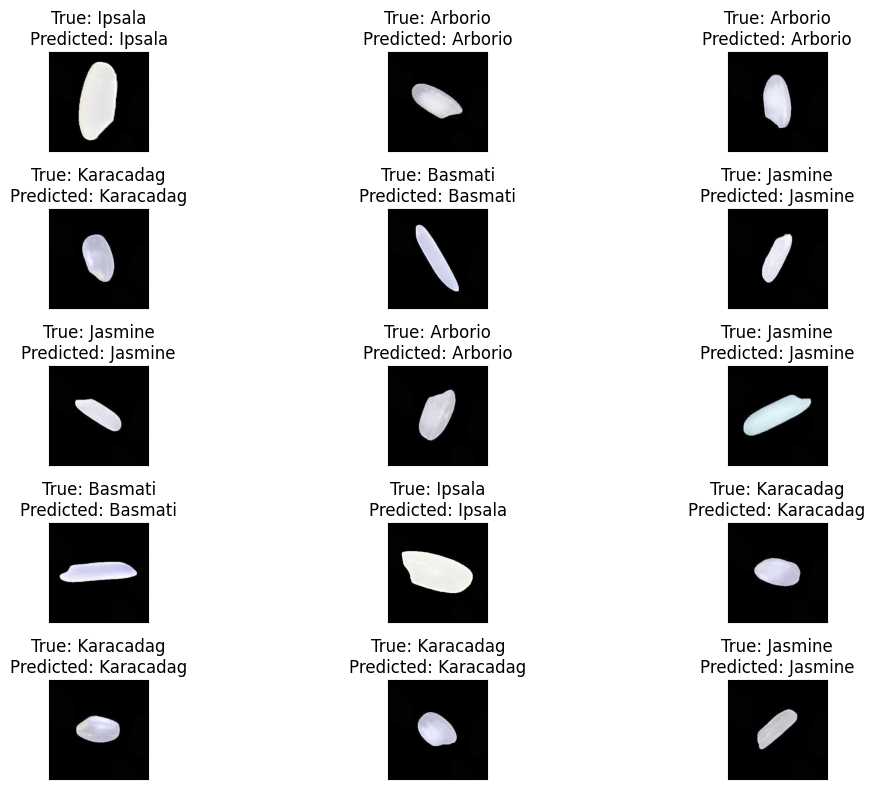

In [31]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 8), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat) :
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
    
plt.tight_layout()
plt.show()

In [32]:
import joblib

joblib.dump(model, 'rice_model.pkl')

['rice_model.pkl']

: 